In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torch import cuda

device = "cuda" if cuda.is_available() else "cpu"

def create_mimo(architecture, data_dim=1, ens_size=1):
    """Create a MIMO model by expanding input/ouput layer by ensemble size."""
    # The only modification needed by MIMO: expand input/output layer by ensemble size
    num_logits = 1  # Since this is a regression problem.
    inputs_size = data_dim * ens_size
    outputs_size = num_logits * ens_size
    
    layers = []
    prev = inputs_size
    layers.append(nn.Flatten())
    for units in architecture:
        layers.append(nn.Linear(prev, units))
        layers.append(nn.ReLU())
        prev = units
    layers.append(nn.Linear(prev, outputs_size))

    return nn.Sequential(*layers)



In [2]:
from torch.distributions.uniform import Uniform

class SimpleDataset(data.Dataset):
    def __init__(self, input, target):
        self.x = input
        self.y = target

    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[[idx],:], self.y[[idx], :]


def create_data(n, data_dim=1, data_noise=0.02, batch_size=8, support=(-1., 1.)):
  """Create regression data from Blundell et al (2016)
  
  Args: 
    n: (int) Sample size.
    data_dim: (int) The dimensionality of the features. 
      A 1D feature will first be created, and if data_dim > 1. It will be 
      projected to data_dim using a random Gaussian matrix.
    data_noise: (float) The standard deviation of the observation noise in the data-generation mechanism.
    batch_size: (int) Batch size for the tf dataset to be generated.
    support: (tuple of float) Range of X to sample the 1D feature from.

  Returns:
    X0: (ndarray) Original 1D features, shape (n, 1)
    y: (ndarray) Response, shape (n, 1)
    X: (ndarray) High-dimensional features obtained by projecting X0 to high dimension, shape (n, data_dim)
    torch_dataloader: 
  """
  # Create 1D features X0.
  lower, upper = support
  X0 = torch.rand(n,1)* (upper-lower) + lower
  noise = torch.rand(n, 1) * data_noise

  # Generate response. 
  y = X0 + 0.3 * torch.sin(2*np.pi * (X0 + noise)) + 0.3 * torch.sin(4*np.pi * (X0 + noise)) + noise

  # Embed X0 into high-dimensional space.
  X = X0
  if data_dim > 1:
    Proj_mat = torch.randn(1, data_dim)
    X = torch.matmul(X0, Proj_mat)

  # Produce high-dimensional dataset.
  torch_dataset = SimpleDataset(X.to(device), y.to(device))
  torch_dataloader = data.DataLoader(torch_dataset, batch_size, shuffle=True)

  return X0.to(device), y.to(device), X.to(device), torch_dataloader

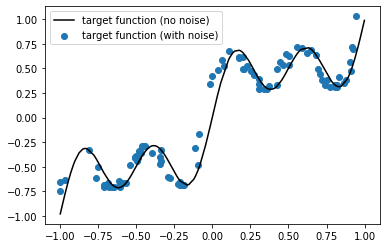

In [3]:
from matplotlib import pyplot as plt

torch.manual_seed(100)

X0_noiseless, y_noiseless, _, _ = create_data(200, data_noise=0.0, data_dim=64)
argsort = torch.argsort(X0_noiseless, 0).flatten()
X0_noiseless = X0_noiseless[argsort]
y_noiseless = y_noiseless[argsort]

X0, y, _, _ = create_data(100, data_noise=0.08)
plt.plot(X0_noiseless.detach().cpu().numpy(), y_noiseless.detach().cpu().numpy(), 'k-', label='target function (no noise)')
plt.scatter(X0.detach().cpu().numpy(), y.detach().cpu().numpy(), label='target function (with noise)')
plt.legend()
plt.show()

Training


In [3]:
def train(model, data_loader, optimizer, ens_size):

    model.train()

    total_loss = 0

    for batch_id, (input, target) in enumerate(data_loader):

        input = input.to(device).float()
        target = target.to(device).float()
        inputs = [input]
        targets = [target]
        for _ in range(ens_size - 1):
            idx = torch.randperm(target.size(0))
            shuffled_in = input[idx].to(device)
            shuffled_trg = target[idx].to(device)
            inputs.append(shuffled_in)
            targets.append(shuffled_trg)
        inputs = torch.cat(inputs, dim=1)
        targets = torch.cat(targets, dim=1).squeeze(-1)
        optimizer.zero_grad()

        loss_fun = nn.MSELoss()
        pred = model(inputs)
        loss = loss_fun(pred, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss
    return total_loss.item()/len(data_loader)

def test(model, data_loader):
    
    model.eval()

    test_loss = 0

    with torch.no_grad():
        for batch_id, (input, target) in enumerate(data_loader):
           
            input = input.to(device).float()
            target = target.to(device).float()

            output = model(input)

            loss_fun = nn.MSELoss()
            pred = model(input)
            loss = loss_fun(pred, target)

            test_loss += loss
            
    return test_loss.item()/len(data_loader)

In [4]:
!pip install tqdm

from tqdm.notebook import trange

In [5]:
def run_mimo(architecture=(32, 128), ens_sizes=(1, 2, 3, 4, 5),
                         lr=0.01, batch_size=4, n_epochs=2000,
                         data_dim=1, data_noise=0.08, 
                         n_train=64, n_test=3000, num_reps=20,
                         eval_epoch=2, print_epoch=-1):
  """Train MIMO model with different ensemble sizes over multiple random seeds.
  
  Args:
    architecture: (tuple of int) Number of units in each hidden layer the MIMO MLP model.
    ens_sizes: (tuple of int) Ensemble sizes for MIMO model to evaluate in experiments.
    lr: (float) Learning rate.
    batch_size: (int) Batch size used for training.
    n_epochs: (int) Number of training epochs.
    data_dim: (int) Dimensionality of the input features.
    data_noise: (float) The standard deviation of the observation noise in the data-generation mechanism.
    n_train: (int) Number of training examples.
    n_test: (int) Number of test examples.
    num_reps: (int) Number of repetitions to conduct for each ensemble size.
    eval_epoch: (int) Record eval results every eval_epoch.
    print_epoch: (int) Print eval results every print_epoch. Set to -1 to disable.

  Returns: 
    Xtest0: (ndarray) Original 1D features for testing data with support in 
      (-1., 1.), shape (n, 1)
    ytest: (ndarray) Response for testing data, shape (n, 1)
    ytest_pred: (dict) A nested dictionary storing evaluation result for each 
      repetition, each ensemble size, and for specified epochs.
    Xtest0_wide: (ndarray) Similar to Xtest0 but from a testing dataset sampled 
      from a wider support (-2., 2.), shape (n, 1)
    ytest_wide: (ndarray) Similar to ytest but from a wider-support test dataset, 
      shape (n, 1)
    ytest_wide_pred: (dict) Similar to ytest_pred but from a wider-support test 
      dataset.
  """
  torch.manual_seed(0)

  # Create testing data.
  Xtest0, ytest, Xtest, _ = create_data(n_test, data_dim=data_dim, 
                                   data_noise=data_noise, support=(-1.,1.))
  Xtest0_wide, ytest_wide, Xtest_wide, _ = create_data(n_test, data_dim=data_dim, 
                                             data_noise=data_noise, support=(-2.,2.))

  # Train MIMO models with different ensemble sizes over multiple random seeds.
  ytest_pred = {}
  ytest_wide_pred = {}

  for rep in range(num_reps):
    print('Repetition', rep)

    _, y, X, training_loader = create_data(n_train, data_dim=data_dim, 
                                        data_noise=data_noise, batch_size=batch_size)

    ytest_pred[rep] = {}
    ytest_wide_pred[rep] = {}

    for ens_size_id in trange(len(ens_sizes)):
      # Specified ensemble size.
      ens_size = ens_sizes[ens_size_id]

      ytest_pred[rep][ens_size] = {}
      ytest_wide_pred[rep][ens_size] = {}

      # Train a MIMO model.
      
      mimo_mlp = create_mimo(architecture, data_dim=data_dim,
                             ens_size=ens_size).to(device)
      print(mimo_mlp)
      
      optimizer = torch.optim.Adam(mimo_mlp.parameters(), lr=lr)

      for epoch in range(n_epochs):
        loss = train(mimo_mlp, training_loader, optimizer, ens_size)

        if print_epoch > 0 and epoch % print_epoch == 0:
          print('[{:4d}] train sq. loss {:0.3f}'.format(epoch, loss))

        if epoch % eval_epoch == 0:
          # Save testing performance.
          per_ens_member_ytest_pred = mimo_mlp(torch.tile(Xtest, (1, ens_size)))
          ytest_pred[rep][ens_size][epoch] = per_ens_member_ytest_pred

          per_ens_member_ytest_wide_pred = mimo_mlp(torch.tile(Xtest_wide, (1, ens_size)))
          ytest_wide_pred[rep][ens_size][epoch] = per_ens_member_ytest_wide_pred  

  return Xtest0, ytest, ytest_pred, Xtest0_wide, ytest_wide, ytest_wide_pred

In [6]:
experiment_config = dict(
    data_dim=1, 
    architecture=(32, 128),
    n_train=64, 
    n_test=3000, 
    num_reps=20,
    lr=0.01,
    n_epochs=2000, 
    ens_sizes=(1,2,3,4,5))

In [7]:
Xtest, ytest, ytest_pred, Xtest_wide, ytest_wide, ytest_wide_pred = run_mimo(**experiment_config)

Repetition 0


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=1, bias=True)
)
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)


RuntimeError: ignored